#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

## Импорт библиотек и подготовка окружения

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None)

## Подготовка

In [6]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]).sort_index().resample('1H').sum()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df.index.is_monotonic_increasing

True

In [8]:
df.isna().sum()

num_orders    0
dtype: int64

## Анализ

Посмотрим на распределение заказов по часам за все время наблюдений:

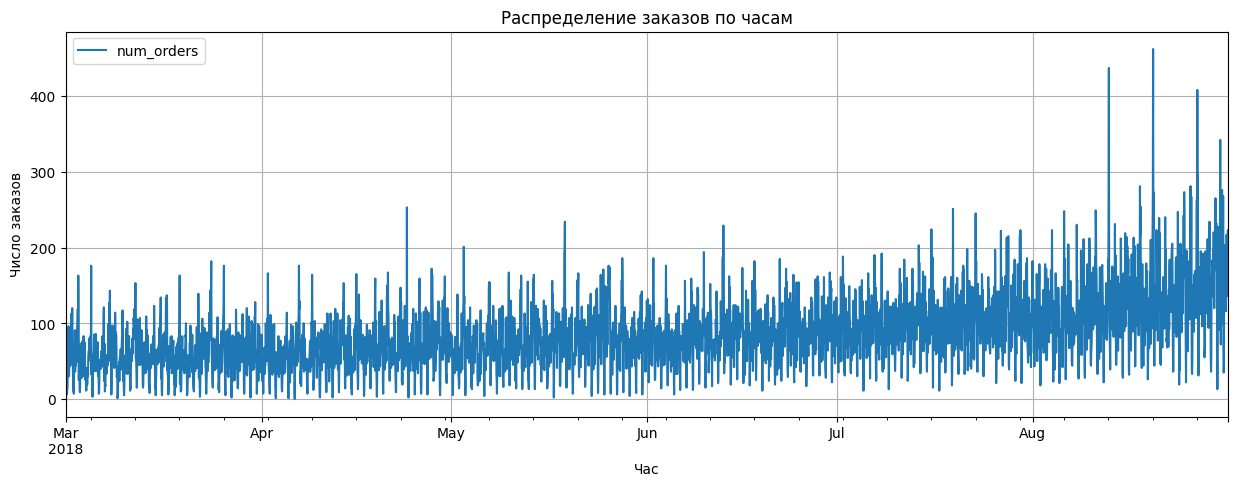

In [9]:
df.plot(figsize=(15, 5), grid=True)
plt.title('Распределение заказов по часам')
plt.xlabel('Час')
plt.ylabel('Число заказов')
plt.show()

Декомпозируем временной ряд на тренд, сезонность и остатки.

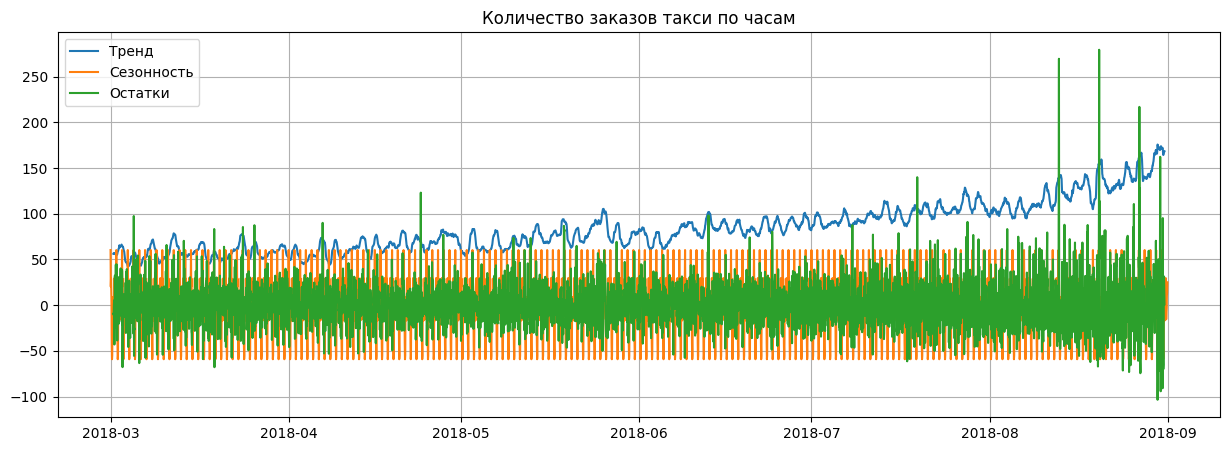

In [10]:
decompose = seasonal_decompose(df)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(decompose.trend, label='Тренд')
ax.plot(decompose.seasonal, label='Сезонность')
ax.plot(decompose.resid, label='Остатки')
plt.grid()
plt.title('Количество заказов такси по часам')
plt.legend()

Есть возрастающий тренд — количество заказов с марта по сентябрь постепенно возрастало.
Посмотрим на сезонность на более узких временных промежутках.

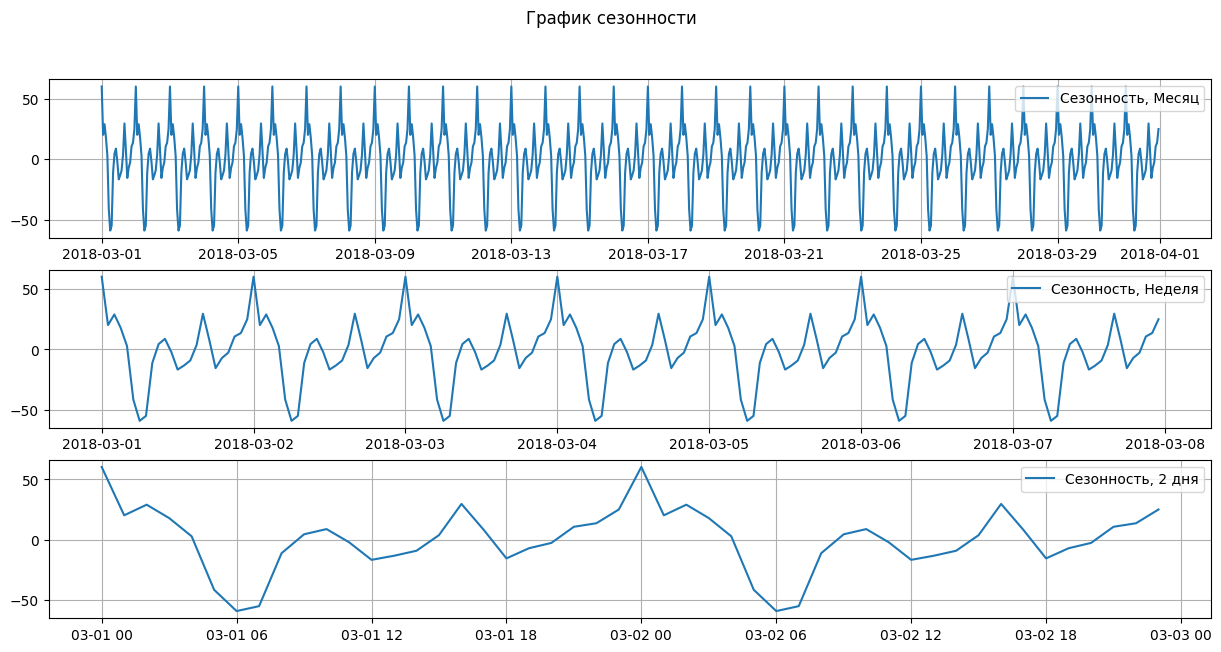

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15, 7))
fig.suptitle('График сезонности')

ax[0].plot(decompose.seasonal['2018-03-01':'2018-03-31'], label='Сезонность, Месяц')
ax[1].plot(decompose.seasonal['2018-03-01':'2018-03-07'], label='Сезонность, Неделя')
ax[2].plot(decompose.seasonal['2018-03-01':'2018-03-02'], label='Сезонность, 2 дня')
[ax[i].grid() for i in range(len(ax))]
[ax[i].legend() for i in range(len(ax))]

"Сезонность" наблюдается в течение дня. Видно, что в поздние часы (в районе 00:00) количество заказов наибольшее, в 6 утра - наименьшее, в то время как днем количество заказов находится по середине.

## Обучение

Определим функцию, которая выделит необходимые для исследования признаки - столбцы с предыдущими значениями временного ряда, скользящее среднее, а также день недели и час. Год не понадобится, тк данные представлены только за 2018 год.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    df_new = data.copy()
    df_new['month'] = df_new.index.month
    df_new['day'] = df_new.index.day
    df_new['dayofweek'] = df_new.index.dayofweek
    df_new['hour'] = df_new.index.hour
# Создаем признаки - значения за предыдущие периоды
    for lag in range(1, max_lag+1):
        df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag)
# Создаем признак "скользящее среднее"
    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    # Удаляем пропуски
    df_new = df_new.dropna(axis=0)
    return df_new

In [13]:
df_new = make_features(df, 10, 10)

In [14]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 10:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [15]:
X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

Определим функцию для обучения моделей и вычиления RMSE:

In [16]:
def model_cv(model, param_grid, n_split):
    tscv = TimeSeriesSplit(n_splits=n_split)
    grid = GridSearchCV(model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=False)
    grid.fit(X_train, y_train)
    rmse = round(abs(grid.best_score_), 3)
    print('RMSE на обучающей выборке:', rmse) 
    print(grid.best_params_)
    return rmse

Линейная регрессия

In [17]:
model = LinearRegression()
rmse_lr = round(abs(cross_val_score(model, X_train, y_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()), 3)
print('RMSE на обучающей выборке:', rmse_lr)

RMSE на обучающей выборке: 30.97


Дерево решений

In [18]:
params =  {'max_depth': range (1, 13, 2),
           'min_samples_leaf': range (1, 8),
           'min_samples_split': range (2, 10, 2)}

rmse_dt = model_cv(DecisionTreeRegressor(), params, 8)

RMSE на обучающей выборке: 28.592
{'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 2}


Случайный лес

In [19]:
params =  {'n_estimators': range(100, 155, 15),
           'max_depth': range (5, 15, 5)}
rmse_rf = model_cv(RandomForestRegressor(), params, 8)

RMSE на обучающей выборке: 24.551
{'max_depth': 10, 'n_estimators': 130}


CatBoost

In [20]:
params =  {'depth': range (7,11, 2),
           'learning_rate': (0.03, 0.1)}

rmse_cb = model_cv(CatBoostRegressor(verbose=False), params, 8)

RMSE на обучающей выборке: 24.335
{'depth': 7, 'learning_rate': 0.03}


Результаты

In [21]:
results = pd.DataFrame([
    [rmse_lr],
    [rmse_dt],
    [rmse_rf],
    [rmse_cb]], 
    columns=['RMSE'],
    index=['LinearRegression', 'DecisionTree', 'RandomForest', 'CatBoost'])

results.sort_values(by='RMSE')

,RMSE
CatBoost,24.335
RandomForest,24.551
DecisionTree,28.592
LinearRegression,30.970


Результаты оценки качества для всех моделей входят в заданное значение 48, лучший результат RMSE показывают RandomForest и CatBoost, худший результат у модели линейной регрессии.

## Тестирование

Проверим наилучшие модели RandomForest и CatBoost на тестовой выборке:

In [22]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = round(mean_squared_error(y_test, y_pred)**0.5, 3)

print('RMSE на тестовой выборке:', rmse)

RMSE на тестовой выборке: 43.602


In [23]:
model = CatBoostRegressor(verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = round(mean_squared_error(y_test, y_pred)**0.5, 3)

print('RMSE на тестовой выборке:', rmse)

RMSE на тестовой выборке: 43.241


Значение RMSE для CatBoost меньше, чем у RandomForest на тестовой выборке и входит в заданное значение 48.

Далее на графике сравним реальные и предсказанные значения:

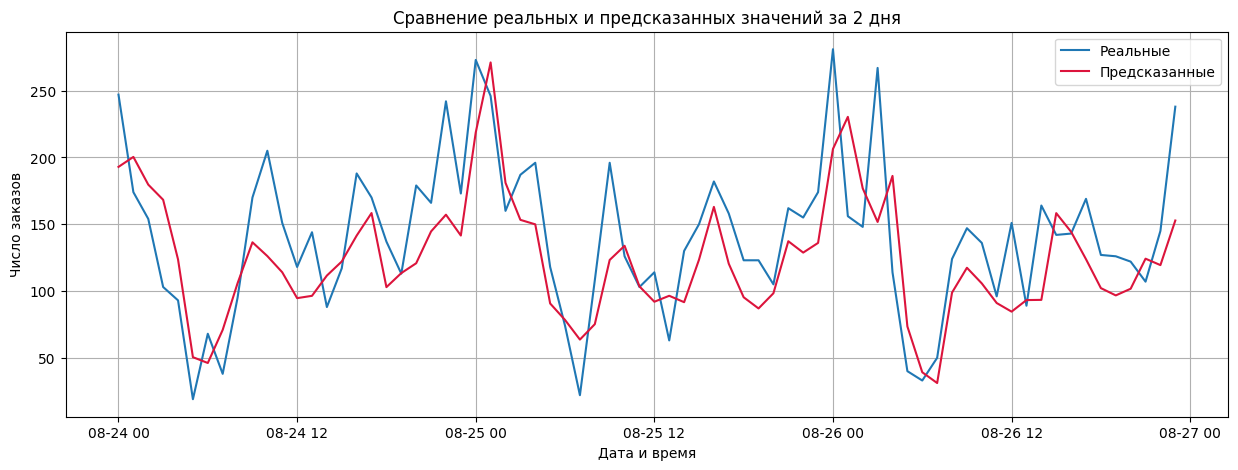

In [24]:
y_pred = pd.Series(y_pred, index=y_test.index)
plt.figure(figsize=(15, 5))
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.plot(y_test['2018-08-24':'2018-08-26'], label='Реальные')
plt.plot(y_pred['2018-08-24':'2018-08-26'], label='Предсказанные', color='crimson')
plt.title('Cравнение реальных и предсказанных значений за 2 дня')
plt.legend()
plt.grid(True)

На графике можно увидеть, что в спокойные часы модель предсказывает неплохо, тогда как в пиковые часы ошибается достаточно сильно.

### Вывод
По результатам исследования можно рекомендовать модель CatBoost как наиболее оптимальный вариант для решения задачи прогнозирования заказов такси на ближайший час.